# Respuestas Desafio Caja de Compensación los Andes
##### Autor: Patricio Flores Videla
##### Mail: patricio.flores.v@ug.uchile.cl
##### Fono: +569 98033767

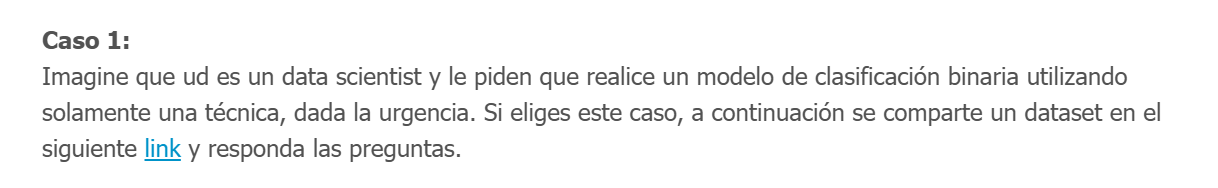

##### Procedemos utilizando python 3.10

In [1]:
# En esta celda vamos a dejar todas las librerías que necesitemos, si usted no tiene instalada alguna de estas
# se le solicita instalar la librería faltante con "pip install..." cuando y donde corresponda.
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, confusion_matrix
from imblearn.over_sampling import BorderlineSMOTE



### Lectura de los datos

In [2]:
# Se descargan los datos y se dejan localmente para no tener que hacer conexiones externas
# Para ejecutar el código correctamente, remplace la siguiente ruta, por la ruta a sus datos:
ruta_datos = "C:\\Users\\Patri\\OneDrive\\Escritorio\\Caja_los_andes\\dataset_Caso_1.csv"
df_caso1 = pd.read_csv(ruta_datos)
df_caso1

,x1,x2,x3,x4,x5,x6,x7,x8,target
0,50.1341,-326.0000,SAT,MZBER,0,0,6,-6.5,0
1,50.1341,-326.0000,SAT,MZBER,0,0,6,-4.5,0
2,124.3276,-275.1935,LCV,MZBER,0,0,3,-2.5,0
3,50.1341,-326.0000,SAT,MZBER,0,0,3,-4.5,0
4,85.3905,-298.8632,XJB,MZBER,0,0,5,-4.5,0
...,...,...,...,...,...,...,...,...,...
1995,119.2548,-283.6687,QKP,MZBER,0,0,3,-2.5,0
1996,106.2410,-294.7023,XJB,YEQA,0,0,3,-2.5,0
1997,127.0572,-295.2308,SAT,MZBER,0,0,3,-5.5,0
1998,114.4653,-290.3312,LCV,MZBER,0,0,3,-5.5,0


###  Hagamos un breve analisis exploratorio de los datos: 

#### Revisión de tipos de datos
A simple vista tenemos un set de datos con 2000 filas y 9 columnas, de estas 9 columnas tenemos variables numericas de punto flotante "float" (x1, x2 y x8) y también numericas de tipo entero "int" (x5, x6 y x7), también tenemos dos columnas de variables de categorías (x3 y x4, las pasaremos a númericas) y finalmente tenemos una columna o variable objetivo (target), ahora proseguimos a explorar de mejor manera la información entregada.

In [3]:
df_caso1.describe()

,x1,x2,x5,x6,x7,x8,target
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000
mean,101.074885,-298.282145,0.01250,0.027000,3.440500,-5.343500,0.011000
std,22.670474,16.596490,0.11113,0.162124,0.972591,1.570108,0.104329
min,50.134100,-326.000000,0.00000,0.000000,3.000000,-7.500000,0.000000
25%,89.501675,-308.930400,0.00000,0.000000,3.000000,-6.500000,0.000000
50%,105.236100,-297.825600,0.00000,0.000000,3.000000,-5.500000,0.000000
75%,116.023175,-288.169025,0.00000,0.000000,3.000000,-4.500000,0.000000
max,150.134100,-226.000000,1.00000,1.000000,8.000000,-1.500000,1.000000


In [4]:
df_caso1.dtypes

x1        float64
x2        float64
x3         object
x4         object
x5          int64
x6          int64
x7          int64
x8        float64
target      int64
dtype: object

### Revisión de posibles vacíos, null, nan.
Al parecer no tenemos valores nulos o faltantes.

In [5]:
# Revisemos si hay y la cantidad de valores nulos/Nan por columna
print(df_caso1.isnull().sum())

x1        0
x2        0
x3        0
x4        0
x5        0
x6        0
x7        0
x8        0
target    0
dtype: int64


In [6]:
# Detectemos posibles celdas vacías en el set de datos
print((df_caso1 == "").sum())

x1        0
x2        0
x3        0
x4        0
x5        0
x6        0
x7        0
x8        0
target    0
dtype: int64


##### Revisemos si existen columnas que entregan información no util (por ejemplo, que todos los elementos de alguna columna sean iguales siempre)

No tenemos columnas con un unico valor, además, podemos ver que la columna objetivo sólo tiene 2 posibles valores que ya indicamos númericos (int).

In [7]:
conteo_unicos = df_caso1.nunique()
print(conteo_unicos)

x1        1183
x2        1149
x3           4
x4           4
x5           2
x6           2
x7           5
x8           7
target       2
dtype: int64


### Ahora revisemos el balanceo de la variable objetivo

##### Encontramos un claro desbalance entre los target entregados, de aproximadamente un 98,9% la categoría objetivo '0' y 1,1% categoría objetivo '1'. Dado esto, para poder utilizar los datos debemos balancear la información, caso contrario, tendremos un sobre entrenamiento cargado a la clase mayoritaria.

In [8]:
conteo_valores_target = df_caso1['target'].value_counts()
print(conteo_valores_target)

print("")
clase_max = conteo_valores_target.idxmax()
cantidad_max = conteo_valores_target[clase_max]
print(f"Clase mayoritaria: {clase_max}")
print(f"Cantidad de clase mayoritaria: {cantidad_max}")

print("")
clase_min = conteo_valores_target.idxmin()
cantidad_min = conteo_valores_target[clase_min]
print(f"Clase mayoritaria: {clase_min}")
print(f"Cantidad de clase mayoritaria: {cantidad_min}")

print("")
print("Proporción de target mayoritario:", cantidad_max/len(df_caso1))
print("Proporción de target minoritario:", cantidad_min/len(df_caso1))

target
0    1978
1      22
Name: count, dtype: int64

Clase mayoritaria: 0
Cantidad de clase mayoritaria: 1978

Clase mayoritaria: 1
Cantidad de clase mayoritaria: 22

Proporción de target mayoritario: 0.989
Proporción de target minoritario: 0.011


#### Pasamos las variables de string (categoricas) a numericas:

In [9]:
# Lista de columnas categóricas a transformar
columnas_categoricas = ["x3", "x4"]  # Reemplaza con los nombres de tus columnas

for columna in columnas_categoricas:
    df_caso1[columna] = pd.factorize(df_caso1[columna])[0]

In [10]:
df_caso1

,x1,x2,x3,x4,x5,x6,x7,x8,target
0,50.1341,-326.0000,0,0,0,0,6,-6.5,0
1,50.1341,-326.0000,0,0,0,0,6,-4.5,0
2,124.3276,-275.1935,1,0,0,0,3,-2.5,0
3,50.1341,-326.0000,0,0,0,0,3,-4.5,0
4,85.3905,-298.8632,2,0,0,0,5,-4.5,0
...,...,...,...,...,...,...,...,...,...
1995,119.2548,-283.6687,3,0,0,0,3,-2.5,0
1996,106.2410,-294.7023,2,2,0,0,3,-2.5,0
1997,127.0572,-295.2308,0,0,0,0,3,-5.5,0
1998,114.4653,-290.3312,1,0,0,0,3,-5.5,0


### Ahora que ya exploramos los datos y los revisamos, lo que nos falta es corregir el desbalanceo de las clases objetivo, para esto tenemos 2 formas de hacerlo (realmente hay más de 2, pero dada la 'urgencia' solicitada, vamos por lo más tradicional)

1.- Eliminar los datos que tiene mayor representación (submuestreo de la data original), el problema con esto es que podemos estar perdiendo mucha información valiosa y debido al poco conocimiento real de los datos, la baja cantidad de data de la clase minoritaria (sólo 22 elementos), esta opción no me parece la más acertada.

2.- Crear datos sinteticos para aumentar la clase con menor representación (sobremuestreo), el problema con esto es que podemos generar un sobre entrenamiento del modelo sobre esta clase (overfitting).

#### Dado lo anterior, escogeremos el sobremuestro a realizar, pero, sólo sobre nuestros datos de entrenamiento:

### División de conjuntos (entrenamiento y prueba) 
Ya con el analisis exploratorio y los datos 'arreglados' o 'corregidos' para su correcto uso, procedemos a realizar la división de conjuntos de entrenamiento y prueba clasicos, utilicemos el tipico 80/20

In [11]:
X = df_caso1.drop('target', axis=1)
y = df_caso1['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Seteamos la semilla para hacer replicable el experimento


### Aplicamos el oversampling al conjunto de entrenamiento

In [12]:
# Normalizar datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Implementación del modelo
Dado que nos están solicitando un modelo con urgencia, inicialmente se considera utilizar una regresión logistica, la cual es sencilla y popular, pero, cómo vimos, tenemos una clase muy desbalanceada que intentamos balancear con oversampling, sin embargo, la regresión es relativamente sensible a este aumento ficticio de datos y también al desbalanceo, por lo que se prefiere buscar una siguiente alternativa.

Luego, considerando los datos, se plantea la opción de utilizar un XGBoost, dada la potencia del modelo, sin embargo, también aumenta significativamente la complejidad para ajustar correctamente el modelo y considerando que se está utilizando una máquina local (no muy potente cabe destacar), se cree que XGBoost podría ser una buena solución, pero algo complicada, si la siguiente solución no funciona, re utilizará.

Ya con lo anterior decidimos utilizar un modelo sencillo (de los más típicos), comprobado por pares y que se ajuste bien al sobre muestreo realizado o directamente sobre datos desbalanceados (por la absurda diferencia porcentual entre clases se decidió balancear la data), dado lo anterior, nos decantamos por un simple pero robusto arbol de decisión o **Random Forest**, pues, es robusto frente a oversampling y a su vez un modelo más sencillo frente XGBoost.

#### DISCLAIMER, LUEGO DE INTENTAR HACER UN BUEN RANDOMFOREST, NO SE LOGRÓ UN FUNCIONAMIENTO MEJOR QUE LO SIGUIENTE


 - AUC Train: 0.9990500316656111
 - F1-score Train: 0.9990509332489719
 - AUC Test: 0.4849624060150376
 - F1-score Test: 0.0

ESTOS VALORES SON TAN MALOS QUE DECIDIMOS NO SEGUIR PELEANDO MUCHO MÁS CON UN RANDOMFOREST Y LANZARNOS POR EL XGBoost


In [13]:



# Aplicar oversampling SOLO en entrenamiento
smote = SMOTE(sampling_strategy=0.1, random_state=42)  # Ajustamos a 50% la clase minoritaria
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


# Normalizar características
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

# Ajustamos scale_pos_weight basado en el dataset original
pos_weight = (y == 0).sum() / (y == 1).sum()

# Definir modelo XGBoost con parámetros ajustados
xgb_model = xgb.XGBClassifier(
    n_estimators=1000, 
    max_depth=2, 
    learning_rate=0.1, 
    gamma=0.4, 
    reg_lambda=15, 
    reg_alpha=8,
    scale_pos_weight=pos_weight,  # Ajusta peso de la clase minoritaria
    random_state=42,
    use_label_encoder=False
)

# Entrenar modelo
xgb_model.fit(X_train_res, y_train_res)

# Obtener probabilidades
y_train_proba = xgb_model.predict_proba(X_train_res)[:, 1]
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Buscar mejor umbral basado en F1-score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold = thresholds[np.argmax(f1_scores[:-1])]

# Aplicar el umbral óptimo
y_train_pred = (y_train_proba > best_threshold).astype(int)
y_test_pred = (y_test_proba > best_threshold).astype(int)

# Calcular métricas
auc_train = roc_auc_score(y_train_res, y_train_proba)
f1_train = f1_score(y_train_res, y_train_pred)
auc_test = roc_auc_score(y_test, y_test_proba)
f1_test = f1_score(y_test, y_test_pred)

# Imprimir resultados
print(f"AUC Train: {auc_train:.4f}")
print(f"F1-score Train: {f1_train:.4f}")
print(f"AUC Test: {auc_test:.4f}")
print(f"F1-score Test: {f1_test:.4f}")
print(f"Mejor umbral: {best_threshold:.4f}")

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión:")
print(conf_matrix)


c:\Users\Patri\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [01:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC Train: 0.9982
F1-score Train: 0.9281
AUC Test: 0.6285
F1-score Test: 0.0000
Mejor umbral: 0.9100
Matriz de confusión:
[[386  10]
 [  4   0]]


C:\Users\Patri\AppData\Local\Temp\ipykernel_11932\1027144788.py:36: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
